In [398]:
from pathlib import Path
from collections import defaultdict

from Bio.Phylo.BaseTree import Tree
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from src.datasets.load_trees import load_trees_from_file
from src.utils.tree_utils import get_taxa_names
from src.distribution_analysis.process_tree import get_observed_nodes

In [399]:
import warnings
warnings.filterwarnings('ignore')
sns.set_style("darkgrid")

In [400]:
REFERENCE_TREE_DIR = Path("data/mcmc_config")
MAP_TREE_DIR = Path("data/map_data")

# REFERENCE_TREE_DIR = Path("data_old/lphy")
# MAP_TREE_DIR = Path("data_old/map_validation")

In [401]:
def rooted_branch_score(tree_1: Tree, tree_2: Tree) -> float:
    taxa_names = get_taxa_names(tree_1)

    nodes_1, _ = get_observed_nodes([tree_1], taxa_names)
    nodes_2, _ = get_observed_nodes([tree_2], taxa_names)

    clades_to_node_1 = {node.node_bitstring: node for node in nodes_1}
    clades_to_node_2 = {node.node_bitstring: node for node in nodes_2}

    rbs = 0.0

    all_clades = set(clades_to_node_1.keys()) | set(clades_to_node_2.keys())

    for clade in all_clades:
        if node_1 := clades_to_node_1.get(clade):
            branch_1 = node_1.height - node_1.parent_height
        else:
            branch_1 = 0.0

        if node_2 := clades_to_node_2.get(clade):
            branch_2 = node_2.height - node_2.parent_height
        else:
            branch_2 = 0.0

        rbs += abs(branch_1 - branch_2)

    return rbs


def squared_rooted_branch_score(tree_1: Tree, tree_2: Tree) -> float:
    taxa_names = get_taxa_names(tree_1)

    nodes_1, _ = get_observed_nodes([tree_1], taxa_names)
    nodes_2, _ = get_observed_nodes([tree_2], taxa_names)

    clades_to_node_1 = {node.node_bitstring: node for node in nodes_1}
    clades_to_node_2 = {node.node_bitstring: node for node in nodes_2}

    srbs = 0.0

    all_clades = set(clades_to_node_1.keys()) | set(clades_to_node_2.keys())

    for clade in all_clades:
        if node_1 := clades_to_node_1.get(clade):
            branch_1 = node_1.height - node_1.parent_height
        else:
            branch_1 = 0.0

        if node_2 := clades_to_node_2.get(clade):
            branch_2 = node_2.height - node_2.parent_height
        else:
            branch_2 = 0.0

        srbs += (branch_1 - branch_2)**2

    return srbs


def height_score(tree_1: Tree, tree_2: Tree) -> float:
    taxa_names = get_taxa_names(tree_1)

    nodes_1, _ = get_observed_nodes([tree_1], taxa_names)
    nodes_2, _ = get_observed_nodes([tree_2], taxa_names)

    clades_to_node_1 = {node.node_bitstring: node for node in nodes_1}
    clades_to_node_2 = {node.node_bitstring: node for node in nodes_2}

    hs = 0.0

    all_clades = set(clades_to_node_1.keys()) | set(clades_to_node_2.keys())

    for clade in all_clades:
        if (node_1 := clades_to_node_1.get(clade)) and (node_2 := clades_to_node_2.get(clade)):
            hs += abs(node_1.height - node_2.height)
        elif node_1:
            hs += node_1.height - node_1.parent_height
        elif node_2:
            hs += node_2.height - node_2.parent_height

    return hs

In [402]:
def get_common_ancestor_clade(ref_clade: int, query_clades: list[int]) -> int:
    if ref_clade in query_clades:
        return ref_clade
    
    matching_clades = (
        query_clade
        for query_clade in query_clades
        if query_clade & ref_clade == ref_clade
    )
    return min(matching_clades, key=lambda x: x.bit_length())

def heights_error(query_tree: Tree, ref_tree: Tree) -> float:
    taxa_names = get_taxa_names(ref_tree)

    query_nodes, _ = get_observed_nodes([query_tree], taxa_names)
    ref_nodes, _ = get_observed_nodes([ref_tree], taxa_names)

    query_clades_to_node = {node.node_bitstring: node for node in query_nodes}
    ref_clades_to_node = {node.node_bitstring: node for node in ref_nodes}

    heights_error = 0.0

    for query_clade, node in query_clades_to_node.items():
        ref_clade = get_common_ancestor_clade(query_clade, list(ref_clades_to_node.keys()))
        
        heights_error += abs(node.height - ref_clades_to_node[ref_clade].height)

    return heights_error

In [403]:
map_trees_per_dataset: dict[tuple[str, str], list[Path]] = defaultdict(list)

for map_tree in MAP_TREE_DIR.glob("*.trees"):
    file_name_wo_ext = map_tree.name.removesuffix(".trees")
    dataset_name, run, model_name = file_name_wo_ext.split("_")

    # dataset_name = "_".join(x.split("-")[:-1])
    # run = x.split("-")[-1]

    map_trees_per_dataset[(dataset_name, run)].append(map_tree)

In [404]:
SCORES = {
    "RBS": rooted_branch_score,
    "SRBS": squared_rooted_branch_score,
    "HS": height_score,
}
NUM_SCORES = len(SCORES)

In [405]:
scores_dict = {"model": [], "dataset": [], "run": [], **{score: [] for score in SCORES.keys()}}

for (dataset, run), map_files in list(map_trees_per_dataset.items()):
    reference_tree = load_trees_from_file(REFERENCE_TREE_DIR / f"{dataset}_{run}.trees")[
        0
    ]

    for map_file in map_files:
        file_name_wo_ext = map_file.name.removesuffix(".trees")
        *_, model_name = file_name_wo_ext.split("_")

        map_tree = load_trees_from_file(map_file)[0]

        scores_dict["model"].append(model_name)
        scores_dict["dataset"].append(dataset)
        scores_dict["run"].append(run) 
        
        for score, score_func in SCORES.items():
            scores_dict[score].append(score_func(map_tree, reference_tree))

df_scores = pd.DataFrame(scores_dict)

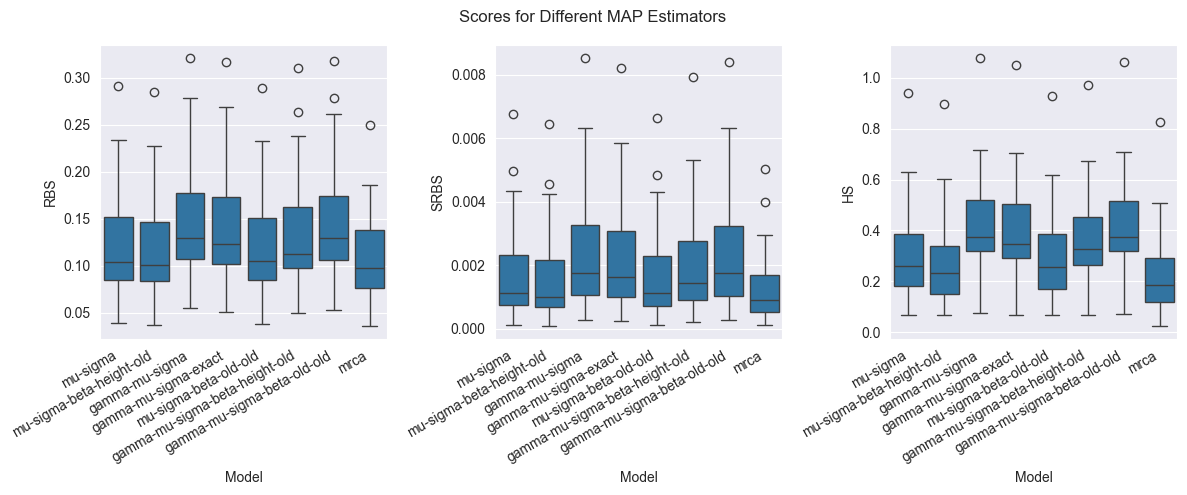

In [406]:
fig, axs = plt.subplots(ncols=NUM_SCORES, figsize=(NUM_SCORES * 4, 5))

for i, score in enumerate(SCORES):
    sns.boxplot(x="model", y=score, data=df_scores, ax=axs[i])
    
    axs[i].set_xlabel("Model")
    axs[i].set_xticks(axs[i].get_xticks(), axs[i].get_xticklabels(), rotation=30, ha='right')

fig.suptitle("Scores for Different MAP Estimators")
plt.tight_layout()

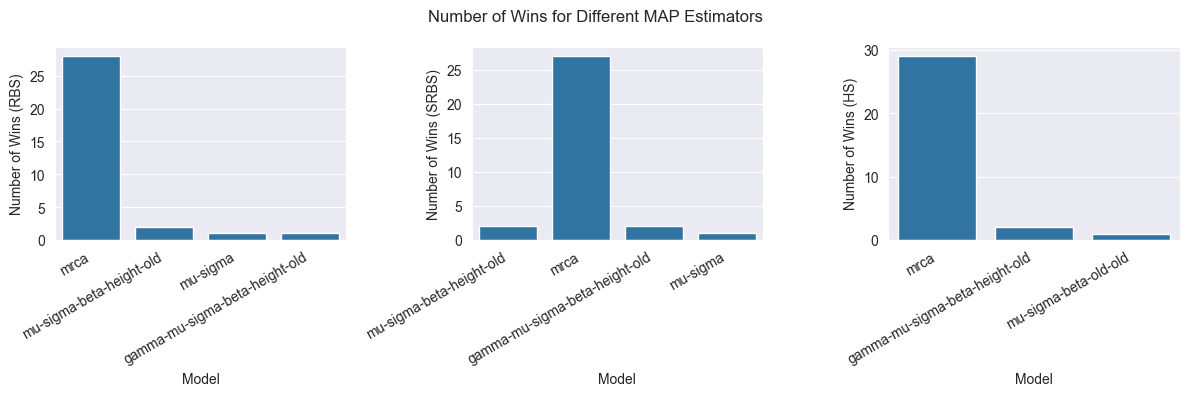

In [407]:
fig, axs = plt.subplots(ncols=NUM_SCORES, figsize=(4*NUM_SCORES, 4))

for i, score in enumerate(SCORES):
    df_score_wins = df_scores.sort_values(score).drop_duplicates(["dataset", "run"])
    
    sns.countplot(data=df_score_wins, x="model", ax=axs[i])

    axs[i].set_xlabel("Model")
    axs[i].set_ylabel(f"Number of Wins ({score})")
    axs[i].set_xticks(axs[i].get_xticks(), axs[i].get_xticklabels(), rotation=30, ha='right')

fig.suptitle("Number of Wins for Different MAP Estimators")
plt.tight_layout()